In [27]:
pip install stop-words

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
#Import the required package.
import pandas as pd
import datetime
import json

In [29]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize,sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewbaber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewbaber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewbaber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/matthewbaber/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [30]:
from nltk.stem import WordNetLemmatizer

In [31]:
from stop_words import get_stop_words
from nltk.corpus import stopwords

In [32]:
#Read the file.
df = pd.read_csv("https://raw.githubusercontent.com/MatticusBa/consultinggroup/main/DATA-462%20Loqbox%20Analytics%20Project%20-%20Membership%20Downgrades%20Data%20(1).csv?token=GHSAT0AAAAAAB6DKJ2W5A53SX7P64ZONFEMY6X7Q2Q")

df

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]"
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ..."
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""..."
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ..."
...,...,...,...,...,...,...,...,...
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""..."
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]"
45061,784914,2022-12-16 13:49:49.000,2022-12-16 13:50:57.000,0,0,0,0,"[{""value"": ""1"", ""reason"": null}]"
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]"


In [33]:
class data_cleaning:

  def __init__(self, df):
    self.df = df

#View the dataframe head.
  def view_df(self, value = 10):
    self.df.value = value
    return self.df.head(value)

#Remove invalid rows.
  def remove_invalid_rows(self):
    self.df = self.df[(self.df['activated_save'] != 0) |
        (self.df['activated_spend'] != 0) |
        (self.df['activated_rent'] != 0) |
        (self.df['activated_coach'] != 0)]
    return self.df

#Output the value and reason from the update_reason column as two new columns separately.
  def separate_update_reason(self):
    self.df["update_reason_dict"] = self.df["update_reason"].str[2:].str[:-2]
    self.df["update_reason_dict"] = self.df["update_reason_dict"].str.split("}, {")
    return self.df

#This code causes the code to misinterpret the value column with "10"s
  def explode(self):
    self.df = self.df.explode("update_reason_dict")
    self.df["update_reason_dict"] = "{" + self.df["update_reason_dict"] + "}"
    a = self.df[self.df.update_reason_dict == "{}"]
    b = self.df[self.df.update_reason_dict != "{}"].dropna()
    c = self.df[self.df.update_reason_dict.isna()]
    b = pd.concat([b, b.update_reason_dict.apply(json.loads).apply(pd.Series)], axis=1)
    self.df = pd.concat([a,b,c])[["customer_id", "upgraded_at", "downgraded_at", "activated_save", "activated_spend","activated_rent", "activated_coach", "update_reason", "value", "reason", "note"]].sort_values(by=["customer_id"])
    return self.df

#Convert the value column to numeric.
  def to_pd_numeric(self):
    self.df.value = pd.to_numeric(self.df.value)
    return self.df

#Split value and reason into multiple columns from 0-7.
  def separate_value_reason(self):
    c=self.df.copy()
    b=self.df.copy()
    self.df['value']=self.df['value'].astype(str)
    a=self.df.groupby(["customer_id","upgraded_at"],as_index=False).apply(lambda x:[','.join(x['value'])])
    a=pd.DataFrame(a)
    a.columns=['customer_id','upgraded_at','values']
    a=pd.merge(c,a)
    for i in range(8):
      a.loc[a['values'].str.contains(str(i)),["value_"+str(i)]]="1"
      a["value_"+str(i)]=a["value_"+str(i)].fillna("0")
    b=b.pivot(index=['customer_id','upgraded_at','note'], columns='value', values=['reason'])
    b.columns=["_".join([str(i)for i in col]).strip() for col in b.columns.values]
    b=b.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
    self.df=pd.merge(a,b)
    return self

#Classificate according to whether the reason is filled in by the users themselves.
  def note_if(self):
    self.df['note t/f'] = self.df["update_reason"].str.startswith(('[{"note"', '[{"reason"'))
    return self

  def reorder_columns(self):
    value_cols = [col for col in self.df.columns if 'value_' in col]
    reason_cols = [col for col in self.df.columns if 'reason_' in col]
    dropcols = value_cols + reason_cols

    cols = [col for col in self.df.columns if col not in dropcols]

    new_order = []
    for i in range(len(value_cols)):
        new_order.append('value_'+str(i)+'')
        new_order.append('reason_'+str(i)+'.0')
    new_order.append('reason_nan')

    self.df = self.df.reindex(columns= cols + new_order)
    return self

#The functions below do not work because they they remove observations before and after the date without classifying them into different dataframes 

"""
#Classificate dataframces by datetime format.
  def format_old(self):
    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at'])
    dt = datetime.datetime(2022,7,20,14,30)
    self.df = self.df[(self.df['downgrade_date'] < dt)]
    return self
    
  def format_new(self):
    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at'])
    dt = datetime.datetime(2022,7,20,14,30)
    self.df = self.df[(self.df['downgrade_date'] > dt)]
    return self

#Classificate observations by the length of time a user has maintained membership.
  def interval(self):
    self.df['upgrade_date'] = pd.to_datetime(self.df['upgraded_at']).dt.date
    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at']).dt.date
    a = self.df['downgrade_date'] - self.df['upgrade_date']
    self.df['interval']=a.astype('timedelta64[D]').astype(int)
    return self

def membership_short(self):
    self.df=interval(self.df)
    self.df=self.df[~(self.df['interval']>14)]
    return self

"""

"\n#Classificate dataframces by datetime format.\n  def format_old(self):\n    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at'])\n    dt = datetime.datetime(2022,7,20,14,30)\n    self.df = self.df[(self.df['downgrade_date'] < dt)]\n    return self\n    \n  def format_new(self):\n    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at'])\n    dt = datetime.datetime(2022,7,20,14,30)\n    self.df = self.df[(self.df['downgrade_date'] > dt)]\n    return self\n\n#Classificate observations by the length of time a user has maintained membership.\n  def interval(self):\n    self.df['upgrade_date'] = pd.to_datetime(self.df['upgraded_at']).dt.date\n    self.df['downgrade_date'] = pd.to_datetime(self.df['downgraded_at']).dt.date\n    a = self.df['downgrade_date'] - self.df['upgrade_date']\n    self.df['interval']=a.astype('timedelta64[D]').astype(int)\n    return self\n\ndef membership_short(self):\n    self.df=interval(self.df)\n    self.df=self.df[~(self.df['inte

In [34]:
dc = data_cleaning(df)
dc.remove_invalid_rows()
dc.separate_update_reason()
dc.explode()
dc.to_pd_numeric()
dc.separate_value_reason()
dc.note_if()
dc.reorder_columns()
        #dc.format_old()
        #dc.format_new()
        #dc.interval()
        #dc.membership_short()

display(dc.view_df(10))

/var/folders/rh/dpkch0xj1dx4bbcqs_mnb3qr0000gn/T/ipykernel_23065/2973683646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["update_reason_dict"] = self.df["update_reason"].str[2:].str[:-2]
/var/folders/rh/dpkch0xj1dx4bbcqs_mnb3qr0000gn/T/ipykernel_23065/2973683646.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["update_reason_dict"] = self.df["update_reason_dict"].str.split("}, {")


,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,value,reason,...,reason_3.0,value_4,reason_4.0,value_5,reason_5.0,value_6,reason_6.0,value_7,reason_7.0,reason_nan
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",10,None,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",10,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",10,I’m not taking advantage of all the benefits o...,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
3,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",10,My current plan isn’t good value for money,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
4,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",10,My current plan is too expensive,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
5,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...",10,None,...,NaN,1,None,0,NaN,0,NaN,0,NaN,NaN
6,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...",10,None,...,NaN,1,None,0,NaN,0,NaN,0,NaN,NaN
7,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...",10,None,...,NaN,1,None,0,NaN,0,NaN,0,NaN,NaN
8,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",10,My current plan is too expensive,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
9,454,2022-11-04 19:24:14.000,2022-11-04 20:56:40.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",10,None,...,NaN,0,NaN,1,None,0,NaN,0,NaN,NaN


In [35]:
df = df[(df['activated_save'] != 0) |
        (df['activated_spend'] != 0) |
        (df['activated_rent'] != 0) |
        (df['activated_coach'] != 0)]
df

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]"
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ..."
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""..."
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ..."
...,...,...,...,...,...,...,...,...
45058,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe..."
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""..."
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]"
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]"


In [36]:
#Split the update_reason column with multiple values and reasons.
df1 = df.copy()

df1["update_reason_dict"] = df1["update_reason"].str[2:].str[:-2]
df1["update_reason_dict"] = df1["update_reason_dict"].str.split("}, {")

df1

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,update_reason_dict
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]","[""value"": ""1"", ""reason"": null]"
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...","[""note"": ""`Member wants to proceed with Save o..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","[""value"": ""0"", ""reason"": ""My current plan is t..."
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","[""value"": ""1"", ""reason"": null, ""value"": ""2"", ""..."
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...","[""value"": ""0"", ""reason"": ""My current plan is t..."
...,...,...,...,...,...,...,...,...,...
45058,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","[""value"": ""1"", ""reason"": ""It's sneaky to offer..."
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","[""value"": ""1"", ""reason"": null, ""value"": ""2"", ""..."
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]","[""value"": ""5"", ""reason"": null]"
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]","[""value"": ""2"", ""reason"": null]"


In [37]:
#Split observations with multiple values in update_reason column into multiple rows.
df2 = df1.explode("update_reason_dict")
df2["update_reason_dict"] = "{" + df2["update_reason_dict"] + "}"

df2

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,update_reason_dict
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]","{""value"": ""1"", ""reason"": null}"
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...","{""note"": ""`Member wants to proceed with Save o..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""0"", ""reason"": ""My current plan is t..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""1"", ""reason"": ""My current plan isn’..."
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""2"", ""reason"": ""I’m not taking advan..."
...,...,...,...,...,...,...,...,...,...
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""1"", ""reason"": null}"
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""2"", ""reason"": null}"
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]","{""value"": ""5"", ""reason"": null}"
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]","{""value"": ""2"", ""reason"": null}"


In [47]:
#Remove the NAN update_reason observations.
df2a = df2[df2.update_reason_dict == "{}"]
df2b = df2[df2.update_reason_dict != "{}"].dropna()
df2c = df2[df2.update_reason_dict.isna()]

In [48]:
#Output the value and reason from the update_reason column as two new columns separately.
df2b = df2b.append([df2b, df2b.update_reason_dict.apply(json.loads).apply(pd.Series)], axis=1)

df2b = df2b.join(df2b.update_reason_dict.apply(json.loads).apply(pd.Series))
df2b = df2b.drop(columns=['update_reason_dict'])
df2b = df2b.reset_index(drop=True)

df2b

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,value,reason,note
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1,None,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2,NaN,`Member wants to proceed with Save only
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0,My current plan is too expensive,NaN
3,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",1,My current plan isn’t good value for money,NaN
4,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",2,I’m not taking advantage of all the benefits o...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
81410,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...",1,None,NaN
81411,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...",2,None,NaN
81412,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5,None,NaN
81413,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2,None,NaN


In [40]:
import re
#Extract the number in the string "value": "{i}" in update_reason_dict column to a new column called value
df2b["value"] = df2b["update_reason_dict"].str.extract(r'{"value": "(.+?)",', expand=True)
df2b['value'] = pd.to_numeric(df2b['value'], errors='coerce')
df2b

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,update_reason_dict,value,reason,note
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]","{""value"": ""1"", ""reason"": null}",1.0,None,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...","{""note"": ""`Member wants to proceed with Save o...",NaN,NaN,`Member wants to proceed with Save only
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""0"", ""reason"": ""My current plan is t...",0.0,My current plan is too expensive,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""1"", ""reason"": ""My current plan isn’...",1.0,My current plan isn’t good value for money,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""2"", ""reason"": ""I’m not taking advan...",2.0,I’m not taking advantage of all the benefits o...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""1"", ""reason"": null}",1.0,None,None
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""2"", ""reason"": null}",2.0,None,None
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]","{""value"": ""5"", ""reason"": null}",5.0,None,None
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]","{""value"": ""2"", ""reason"": null}",2.0,None,None


In [41]:
import re

input_str = '[{"value": "{i}"}]'
json_obj = json.loads(input_str)
#df2b['value'] = json_obj[0]['value'].replace('{', '').replace('}', '')
df2b['value'] = df2b['update_reason_dict'].str.extract(r'(\d+)')
df2b['value'] = pd.to_numeric(df2b['value'], errors='coerce')

df2b

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,update_reason_dict,value,reason,note
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]","{""value"": ""1"", ""reason"": null}",1.0,None,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...","{""note"": ""`Member wants to proceed with Save o...",2.0,NaN,`Member wants to proceed with Save only
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""0"", ""reason"": ""My current plan is t...",0.0,My current plan is too expensive,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""1"", ""reason"": ""My current plan isn’...",1.0,My current plan isn’t good value for money,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","{""value"": ""2"", ""reason"": ""I’m not taking advan...",2.0,I’m not taking advantage of all the benefits o...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""1"", ""reason"": null}",1.0,None,None
45059,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","{""value"": ""2"", ""reason"": null}",2.0,None,None
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]","{""value"": ""5"", ""reason"": null}",5.0,None,None
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]","{""value"": ""2"", ""reason"": null}",2.0,None,None


In [43]:

    df3 = pd.concat([df2a,df2b,df2c])[["customer_id", "upgraded_at", "downgraded_at", "activated_save", "activated_spend","activated_rent", "activated_coach", "value", "reason", "note"]].sort_values(by=["customer_id"])

#drop value column
df3 = df3.drop(columns=['value'])


In [ ]:
#Add NAN update_reason obversations back.

df3.value = pd.to_numeric(df3.value)
df3['upgrade_date'] = pd.to_datetime(df3['upgraded_at'])
df3['downgrade_date'] = pd.to_datetime(df3['downgraded_at'])
df3


,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,value,reason,note,upgrade_date,downgrade_date
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,1.0,None,NaN,2022-06-06 11:05:27,2022-11-16 20:34:41
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,1.0,None,NaN,2022-06-06 11:05:27,2022-11-16 20:34:41
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,2.0,NaN,`Member wants to proceed with Save only,2022-02-12 09:23:22,2022-03-14 16:17:01
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,2.0,NaN,`Member wants to proceed with Save only,2022-02-12 09:23:22,2022-03-14 16:17:01
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,2.0,I’m not taking advantage of all the benefits o...,NaN,2022-03-01 08:49:00,2022-05-08 12:37:56
...,...,...,...,...,...,...,...,...,...,...,...,...
45060,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,5.0,None,NaN,2022-12-16 12:11:55,2022-12-16 12:14:22
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,2.0,None,NaN,2022-12-16 14:14:46,2022-12-16 14:23:11
45062,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,2.0,None,NaN,2022-12-16 14:14:46,2022-12-16 14:23:11
45063,784991,2022-12-16 15:24:35.000,2022-12-16 15:31:53.000,1,0,0,0,5.0,None,NaN,2022-12-16 15:24:35,2022-12-16 15:31:53


In [ ]:
#Add a new column to show which values the user selected
df3['value_str']=df3['value'].astype(str)
df4=df3.groupby(["customer_id","upgraded_at"],as_index=False).apply(lambda x:[','.join(x['value_str'])])
df4=pd.DataFrame(df4)
df4.columns=['customer_id','upgraded_at','values']
df4=pd.merge(df,df4)
df4

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1.0
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2.0
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","2.0,1.0,0.0"
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,2.0,1.0"
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0
...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0"
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0"
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0


In [ ]:
# Xenia's draft
def format_array(df4):
  for i in range(8):
    df4.loc[df4['values'].str.contains(str(i)),["value_"+str(i)]]="1"
    df4["value_"+str(i)]=df4["value_"+str(i)].fillna("0")
  return df4
df4 = format_array(df4)
df4


,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1.0,1,1,0,0,0,0,0,0
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2.0,1,0,1,0,0,0,0,0
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","2.0,1.0,0.0",1,1,1,0,0,0,0,0
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,2.0,1.0",1,1,1,0,1,0,0,0
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0",1,1,1,1,1,1,0,0
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0",1,1,1,0,0,0,0,0
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,0,0,0,0,1,0,0
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0,1,0,1,0,0,0,0,0


In [ ]:
#Separate the different reasons into different columns and combine them
df5=df3.copy()
df5=df3.pivot(index=['customer_id','upgraded_at','note'], columns='value', values=['reason'])
df5.columns=["_".join([str(i)for i in col]).strip() for col in df5.columns.values]
df5=df5.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
df5=pd.merge(df4,df5)
df5.columns

Index(['customer_id', 'upgraded_at', 'downgraded_at', 'activated_save',
       'activated_spend', 'activated_rent', 'activated_coach', 'update_reason',
       'values', 'value_0', 'value_1', 'value_2', 'value_3', 'value_4',
       'value_5', 'value_6', 'value_7', 'note', 'reason_nan', 'reason_0.0',
       'reason_1.0', 'reason_2.0', 'reason_3.0', 'reason_4.0', 'reason_5.0',
       'reason_6.0', 'reason_7.0', 'reason_10.0', 'reason_11.0', 'reason_14.0',
       'reason_48.0', 'reason_50.0', 'reason_471.0', 'reason_2022.0',
       'reason_263864.0'],
      dtype='object')

In [ ]:
# Matt's draft - this just reorders the columns correctly
value_cols = [col for col in df5.columns if 'value_' in col]
reason_cols = [col for col in df5.columns if 'reason_' in col]
dropcols = value_cols + reason_cols

cols = [col for col in df5.columns if col not in dropcols]

cols


['customer_id',
 'upgraded_at',
 'downgraded_at',
 'activated_save',
 'activated_spend',
 'activated_rent',
 'activated_coach',
 'update_reason',
 'values',
 'note']

In [ ]:

#cols = df5.columns.list() - dropcols
#Solution


cols = df5.columns.list() - dropcols

new_order = []
for i in range(len(value_cols)):
    new_order.append('value_'+str(i)+'')
    new_order.append('reason_'+str(i)+'.0')

df5_reordered = df5.reindex(columns= cols + new_order)
df5_reordered.columns.tolist()

AttributeError: 'Index' object has no attribute 'list'

In [ ]:
value_cols = [col for col in df5.columns if 'value_' in col]
reason_cols = [col for col in df5.columns if 'reason_' in col]
cols = ['customer_id', 'upgraded_at', 'downgraded_at', 'activated_save',
       'activated_spend', 'activated_rent', 'activated_coach', 'update_reason',
       'values', 'note', 'reason_nan']

In [ ]:
new_order = []
for i in range(len(value_cols)):
    new_order.append('value_'+str(i)+'')
    new_order.append('reason_'+str(i)+'.0')

df5_reoredered = df5.reindex(columns= cols + new_order)
df5_reoredered


,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,note,...,value_4,reason_4.0,value_5,reason_5.0,value_6,reason_6.0,value_7,reason_7.0,value_8,reason_8.0
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1.0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2.0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","2.0,1.0,0.0",NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,2.0,1.0",NaN,...,1,None,0,NaN,0,NaN,0,NaN,NaN,NaN
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0",NaN,...,1,It's sneaky to offer free help then charge for...,1,It's sneaky to offer free help then charge for...,0,NaN,0,NaN,NaN,NaN
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0",NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,NaN,...,0,NaN,1,None,0,NaN,0,NaN,NaN,NaN
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN


In [ ]:
# Matt's draft
df5b = df5.copy()
cols = ['reason_0.0', 'reason_1.0', 'reason_2.0', 'reason_3.0', 'reason_4.0', 'reason_5.0', 'reason_6.0', 'reason_7.0', 'reason_nan']
for i, col in enumerate(cols):
    df5b.insert(10 + 2 * i, f'reason_{i}', df5b[col])

df5b = df5b.rename(columns={'reason_8': 'reason_nan'})
df5b = df5b.drop(columns=cols)

display(df5b)
display(df5b.columns)

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,value_0,...,reason_3,value_4,reason_4,value_5,reason_5,value_6,reason_6,value_7,reason_7,note
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,`Member wants to proceed with Save only
2,267,2022-03-01 08:49:00.000,2022-05-08 12:37:56.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...","2.0,1.0,0.0",1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,2.0,1.0",1,...,NaN,1,None,0,NaN,0,NaN,0,NaN,NaN
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0",1,...,It's sneaky to offer free help then charge for...,1,It's sneaky to offer free help then charge for...,1,It's sneaky to offer free help then charge for...,0,NaN,0,NaN,NaN
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0",1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,...,NaN,0,NaN,1,None,0,NaN,0,NaN,NaN
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0,1,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN


Index(['customer_id', 'upgraded_at', 'downgraded_at', 'activated_save',
       'activated_spend', 'activated_rent', 'activated_coach', 'update_reason',
       'values', 'value_0', 'reason_0', 'value_1', 'reason_1', 'value_2',
       'reason_2', 'value_3', 'reason_3', 'value_4', 'reason_4', 'value_5',
       'reason_5', 'value_6', 'reason_6', 'value_7', 'reason_7', 'note'],
      dtype='object')

In [ ]:
df5=df5b


In [ ]:
#Classificate obversations according to old and new feedback systems.
df5['upgrade_date'] = pd.to_datetime(df5['upgraded_at']).dt.date
df5['upgrade_time'] = pd.to_datetime(df5['upgraded_at']).dt.time
df5['downgrade_date'] = pd.to_datetime(df5['downgraded_at'])
df5['downgrade_time'] = pd.to_datetime(df5['downgraded_at']).dt.time

In [ ]:
#Splitting dataframces by datetime format 
dt = datetime.datetime(2022,7,20,14,30)
res1 = df5[(df5['downgrade_date'] < dt)] 
res2 = df5[(df5['downgrade_date'] >= dt)]
res2

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,value_0,...,reason_5,value_6,reason_6,value_7,reason_7,note,upgrade_date,upgrade_time,downgrade_date,downgrade_time
0,18,2022-06-06 11:05:27.000,2022-11-16 20:34:41.000,1,0,1,0,"[{""value"": ""1"", ""reason"": null}]",1.0,1,...,NaN,0,NaN,0,NaN,NaN,2022-06-06,11:05:27,2022-11-16 20:34:41,20:34:41
3,332,2022-08-05 23:25:15.000,2022-08-25 15:52:59.000,1,1,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,2.0,1.0",1,...,NaN,0,NaN,0,NaN,NaN,2022-08-05,23:25:15,2022-08-25 15:52:59,15:52:59
5,454,2022-11-04 19:24:14.000,2022-11-04 20:56:40.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,...,None,0,NaN,0,NaN,NaN,2022-11-04,19:24:14,2022-11-04 20:56:40,20:56:40
7,548,2021-11-16 12:04:23.000,2022-09-20 16:31:40.000,1,0,0,0,"[{""note"": ""member request"", ""value"": ""2""}]",2.0,1,...,NaN,0,NaN,0,NaN,member request,2021-11-16,12:04:23,2022-09-20 16:31:40,16:31:40
8,641,2022-03-29 20:16:44.000,2022-12-13 03:11:26.000,1,1,0,0,"[{""value"": ""3"", ""reason"": null}, {""value"": ""4""...","5.0,4.0,3.0",1,...,None,0,NaN,0,NaN,NaN,2022-03-29,20:16:44,2022-12-13 03:11:26,03:11:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0",1,...,It's sneaky to offer free help then charge for...,0,NaN,0,NaN,NaN,2022-12-16,09:52:04,2022-12-16 10:34:04,10:34:04
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0",1,...,NaN,0,NaN,0,NaN,NaN,2022-12-16,11:28:09,2022-12-16 11:43:52,11:43:52
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,...,None,0,NaN,0,NaN,NaN,2022-12-16,12:11:55,2022-12-16 12:14:22,12:14:22
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0,1,...,NaN,0,NaN,0,NaN,NaN,2022-12-16,14:14:46,2022-12-16 14:23:11,14:23:11


In [ ]:
#Classificate observations according to the length of time a user has maintained membership.
df5['upgrade_date'] = pd.to_datetime(df5['upgraded_at']).dt.date
df5['downgrade_date'] = pd.to_datetime(df5['downgraded_at']).dt.date
df5['days'] = df5['downgrade_date'] - df5['upgrade_date']
df5['interval']=df5['days'].astype('timedelta64[D]').astype(int)

gr1=df5[df5['interval']<=14]
gr2=df5[~(df5['interval']<=14)]

gr1

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,value_0,...,reason_6,value_7,reason_7,note,upgrade_date,upgrade_time,downgrade_date,downgrade_time,days,interval
4,445,2022-05-27 07:41:27.000,2022-05-27 07:43:36.000,1,0,0,1,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0,1,...,NaN,0,NaN,NaN,2022-05-27,07:41:27,2022-05-27,07:43:36,0 days,0
5,454,2022-11-04 19:24:14.000,2022-11-04 20:56:40.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,...,NaN,0,NaN,NaN,2022-11-04,19:24:14,2022-11-04,20:56:40,0 days,0
9,661,2022-04-03 19:48:13.000,2022-04-07 08:08:38.000,1,0,0,1,NaN,nan,0,...,NaN,0,NaN,NaN,2022-04-03,19:48:13,2022-04-07,08:08:38,4 days,4
12,894,2022-09-10 09:04:00.000,2022-09-10 09:25:23.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","4.0,1.0,2.0",1,...,NaN,0,NaN,NaN,2022-09-10,09:04:00,2022-09-10,09:25:23,0 days,0
15,1044,2022-02-08 21:11:39.000,2022-02-08 21:13:36.000,1,0,0,0,"[{""value"": ""0"", ""reason"": ""My current plan is ...",0.0,1,...,NaN,0,NaN,NaN,2022-02-08,21:11:39,2022-02-08,21:13:36,0 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44688,784693,2022-12-16 09:52:04.000,2022-12-16 10:34:04.000,1,0,0,0,"[{""value"": ""1"", ""reason"": ""It's sneaky to offe...","1.0,2.0,3.0,4.0,5.0",1,...,NaN,0,NaN,NaN,2022-12-16,09:52:04,2022-12-16,10:34:04,0 days,0
44689,784773,2022-12-16 11:28:09.000,2022-12-16 11:43:52.000,1,0,0,0,"[{""value"": ""1"", ""reason"": null}, {""value"": ""2""...","1.0,2.0",1,...,NaN,0,NaN,NaN,2022-12-16,11:28:09,2022-12-16,11:43:52,0 days,0
44690,784819,2022-12-16 12:11:55.000,2022-12-16 12:14:22.000,1,0,0,0,"[{""value"": ""5"", ""reason"": null}]",5.0,1,...,NaN,0,NaN,NaN,2022-12-16,12:11:55,2022-12-16,12:14:22,0 days,0
44691,784930,2022-12-16 14:14:46.000,2022-12-16 14:23:11.000,1,1,0,1,"[{""value"": ""2"", ""reason"": null}]",2.0,1,...,NaN,0,NaN,NaN,2022-12-16,14:14:46,2022-12-16,14:23:11,0 days,0


In [ ]:
#Classificate according to whether the reason is filled in by the users themselves. #merge this with the rest of the dataframes
df5['note t/f'] = df5["update_reason"].str.startswith(('[{"note"', '[{"reason"'))

notes = df5[(df5['note t/f']==True)]
vals = df5[(df5['note t/f']==False)]

notes

,customer_id,upgraded_at,downgraded_at,activated_save,activated_spend,activated_rent,activated_coach,update_reason,values,value_0,...,value_7,reason_7,note,upgrade_date,upgrade_time,downgrade_date,downgrade_time,days,interval,note t/f
1,252,2022-02-12 09:23:22.000,2022-03-14 16:17:01.000,1,0,0,0,"[{""note"": ""`Member wants to proceed with Save ...",2.0,1,...,0,NaN,`Member wants to proceed with Save only,2022-02-12,09:23:22,2022-03-14,16:17:01,30 days,30,True
7,548,2021-11-16 12:04:23.000,2022-09-20 16:31:40.000,1,0,0,0,"[{""note"": ""member request"", ""value"": ""2""}]",2.0,1,...,0,NaN,member request,2021-11-16,12:04:23,2022-09-20,16:31:40,308 days,308,True
13,905,2022-09-06 21:11:54.000,2022-10-03 12:48:08.000,1,1,0,0,"[{""note"": ""customer request"", ""value"": ""0""}]",0.0,1,...,0,NaN,customer request,2022-09-06,21:11:54,2022-10-03,12:48:08,27 days,27,True
21,1497,2021-11-02 16:19:56.000,2022-07-15 14:34:15.000,1,0,0,0,"[{""note"": ""requested"", ""value"": ""2""}]",2.0,1,...,0,NaN,requested,2021-11-02,16:19:56,2022-07-15,14:34:15,255 days,255,True
25,1689,2022-03-13 03:00:48.000,2022-03-14 13:37:00.000,1,1,0,0,"[{""note"": ""Wants Lite"", ""value"": ""3"", ""reason""...",3.0,1,...,0,NaN,Wants Lite,2022-03-13,03:00:48,2022-03-14,13:37:00,1 days,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44633,782036,2022-12-13 14:30:33.000,2022-12-14 11:20:31.000,1,1,0,1,"[{""note"": ""member request"", ""value"": ""3"", ""rea...",3.0,1,...,0,NaN,member request,2022-12-13,14:30:33,2022-12-14,11:20:31,1 days,1,True
44635,782207,2022-12-13 17:06:28.000,2022-12-13 17:13:57.000,1,0,0,0,"[{""note"": ""Only has lb save"", ""value"": ""2""}]",2.0,1,...,0,NaN,Only has lb save,2022-12-13,17:06:28,2022-12-13,17:13:57,0 days,0,True
44677,783874,2022-12-15 11:36:06.000,2022-12-15 12:09:33.000,1,1,0,1,"[{""note"": ""Member request"", ""value"": ""3"", ""rea...",3.0,1,...,0,NaN,Member request,2022-12-15,11:36:06,2022-12-15,12:09:33,0 days,0,True
44679,783946,2022-12-15 12:42:48.000,2022-12-15 13:16:21.000,1,0,0,0,"[{""note"": ""Did not mean to sign up"", ""value"": ...",3.0,1,...,0,NaN,Did not mean to sign up,2022-12-15,12:42:48,2022-12-15,13:16:21,0 days,0,True


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

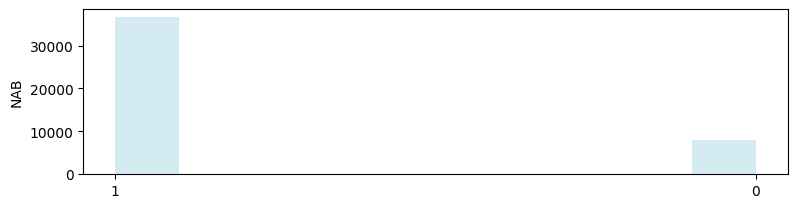

In [ ]:
a = df5['value_0']
b = df5['value_1']
c = df5['value_2']
d = df5['value_3']
e = df5['value_4']
f = df5['value_5']
g = df5['value_6']

y = df5['interval']

#fig = plt.figure()
#fig.set_size_inches(30, 20)
#fig.set_dpi(100)

plt.figure(figsize=(20, 15))

plt.subplot(6, 2, 1)
plt.hist(a, color='lightblue', alpha=0.5)
plt.ylabel('NAB')

plt.show()


<Axes: xlabel='customer_id', ylabel='Density'>

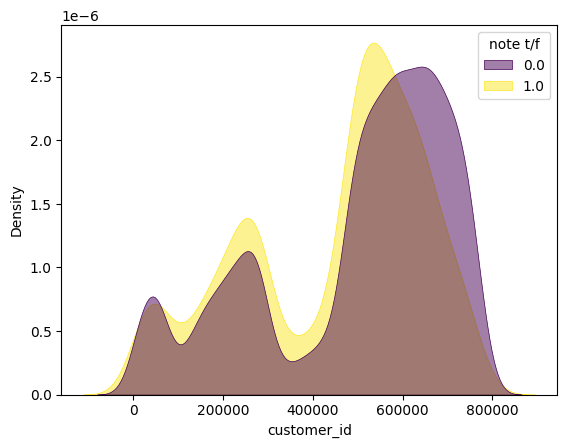

In [ ]:
sns.kdeplot(
   data=df5, x="customer_id", hue="note t/f",
   fill=True, common_norm=False, palette="viridis",
   alpha=.5, linewidth=0.5
)

<Axes: xlabel='interval', ylabel='customer_id'>

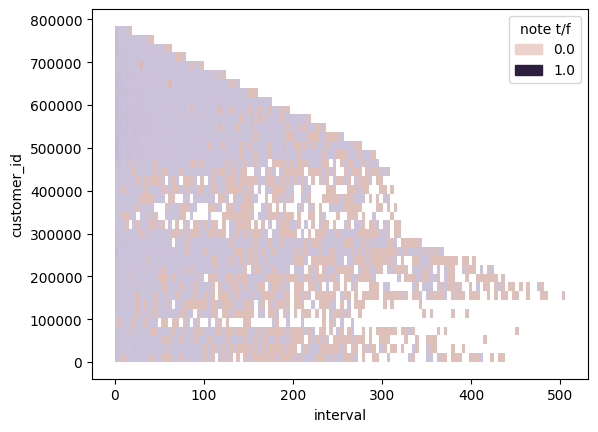

In [ ]:
sns.histplot(data=df5, x="interval", y="customer_id", hue="note t/f")

TypeError: The y variable is categorical, but one of ['numeric', 'datetime'] is required

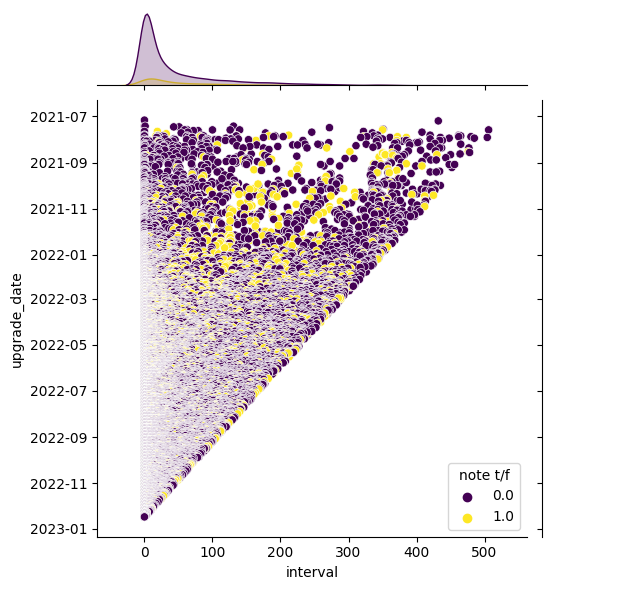

In [ ]:
sns.jointplot(data=df5, x="interval", y="upgrade_date", hue="note t/f", palette="viridis", alpha=1)

In [ ]:
# Data Preprocessing - Danie's draft

In [ ]:
# Split into 2 sub datasets
system_change = datetime.datetime(2022,7,20,14,30)
df3_old = df3[df3.downgrade_date < system_change]
df3_new = df3[df3.downgrade_date >= system_change]

In [ ]:
# Get stop word list
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english')) 
stop_words.extend(nltk_words)

In [ ]:
#Remove rows with NaN reason or non-NaN notes
df3_new_1 = df3_new[(df3_new["reason"].notna()) & (df3_new["note"].isnull())]

In [ ]:
#Remove null Reason/dup Reason, tokenize + remove stop words + lemmatize
df3_new_2 = df3_new[(df3_new["reason"].notna()) & (df3_new["note"].isnull())].drop(columns="value").drop_duplicates(keep="first")
df3_new_2["reason_v2"] = df3_new_2["reason"].apply(word_tokenize)
df3_new_2["reason_v3"] = df3_new_2["reason_v2"].apply(lambda x: [word for word in x if word not in (stop_words)])
lmtzr = WordNetLemmatizer()
df3_new_2["reason_v4"] = df3_new_2["reason_v3"].apply(lambda x: [lmtzr.lemmatize(word) for word in x])

In [ ]:
#Remove rows with NaN reason or non-NaN notes
df3_old_1 = df3_old[(df3_old["reason"].notna()) & (df3_old["note"].isnull())]

#Find written reasons by customers (not suggested by LOQBOX)
distinct_reason = df3_old_1.groupby(['value', 'reason']).size().reset_index(name='counts')
written_reason = distinct_reason[distinct_reason.counts < 20]

In [ ]:
#Remove null Reason/dup Reason, tokenize + remove stop words + lemmatize
df3_old_2 = df3_old[(df3_old["reason"].notna()) & (df3_old["note"].isnull())].drop(columns="value").drop_duplicates(keep="first")
df3_old_2 = df3_old_2[df3_old_2.reason.isin(written_reason.reason)]
df3_old_2["reason_v2"] = df3_old_2["reason"].apply(word_tokenize)
df3_old_2["reason_v3"] = df3_old_2["reason_v2"].apply(lambda x: [word for word in x if word not in (stop_words)])
lmtzr = WordNetLemmatizer()
df3_old_2["reason_v4"] = df3_old_2["reason_v3"].apply(lambda x: [lmtzr.lemmatize(word) for word in x])

In [ ]:
#Combine 2 sub-datasets
df3_all = pd.concat([df3_new_2, df3_old_2])